<font size = 6>EM Applications and its Extension - GMM</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Nov 9, 2022</div></font>

In [1]:
import os
os.add_dll_directory("C:\Program Files\PSG\lib")

from hmmlearn.hmm import GaussianHMM as HMM
from sklearn.mixture import GaussianMixture as GMM
from scipy import integrate
from scipy.stats import norm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import math
import numpy as np
import pandas as pd
import psgpython
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns

data_path = "D:\\Data\\"

In [2]:
def gen_norm_pdf(hmm_model, range_std = 3):
    mean_vec = hmm_model_y.means_.flatten()
    sigma_vec = np.sqrt(hmm_model_y.covars_.flatten())
    lo_vec = mean_vec - range_std * sigma_vec
    up_vec = mean_vec + range_std * sigma_vec
    x_vec = np.linspace(lo_vec.min(), up_vec.max(), int(1e5))
    y_vecs = []
    for i in range(mean_vec.shape[0]):
        curr_dist = norm(mean_vec[i], sigma_vec[i])
        y_vecs.append(curr_dist.pdf(x_vec))
    return np.array(x_vec), np.array(y_vecs), mean_vec, sigma_vec

In [3]:
def discrete_cvar(loss_vec, alpha, dist = "Uniform"):
    if dist != "Uniform":
        raise Exception("Only Accept Uniform Distribution!")

    data = np.sort(loss_vec)[::-1]
    alpha = 1 - alpha
    num = data.shape[0] - 1
    
    if int(num * alpha) == 0:
        raise Exception("Confidnece Level Alpha is not reasonable and is too large!")
    
    # Calculate VaR
    if math.isclose(int(num * alpha), num * alpha, rel_tol=1e-8):
        var_num = int(num * alpha)
        var = data[var_num]    
    else:
        var_num = int(num * alpha)
        right = num * alpha - int(num * alpha)
        left = 1 - right
        var = left * data[var_num + 1] + right * data[var_num]
    # Calculate CVaR+ and CVaR-
    if math.isclose(int(num * alpha), num * alpha, rel_tol=1e-8):
        cvar_plus_num = int(num * alpha) - 1
        cvar_minus_num = int(num * alpha)
    else:
        cvar_plus_num = int(num * alpha)
        cvar_minus_num = int(num * alpha)
    cvar_plus = np.mean(data[:cvar_plus_num + 1])
    cvar_minus = np.mean(data[:cvar_minus_num + 1])
    # Calculate lambda
    phi = 1 - int(num * alpha) / num
    lambda_ = (phi - (1 - alpha)) / alpha
    cvar = var * lambda_ + cvar_plus * (1 - lambda_)
    return cvar, var, cvar_plus, cvar_minus, lambda_

In [4]:
def cvar_single_norm(mean, sigma, alpha):
    norm_dist = norm(mean, sigma)
    return (1 / (1 - alpha)) * integrate.quad(lambda x: x * norm_dist.pdf(x), norm_dist.ppf(alpha), np.inf)[0]

In [5]:
def GMM_Model(weight, mean, sigma):
    GMM_model = pd.DataFrame({"mean": mean, "sigma": sigma, "weight": weight}).sort_values(by = "weight", ascending = False)
    GMM_model.reset_index(drop = True, inplace = True)
    return GMM_model

In [6]:
def GMM_pdf(weight, mean, sigma, x_vec):
    GMM_model = GMM_Model(weight, mean, sigma)
    
    y_vec = np.array([0.] * x_vec.shape[0])
    for i in range(GMM_model.shape[0]):
        norm_dist = norm(GMM_model["mean"][i], GMM_model["sigma"][i])
        y_vec += GMM_model["weight"][i] * norm_dist.pdf(x_vec)
    
    return y_vec

In [7]:
def GMM_cdf(weight, mean, sigma, x_vec):
    GMM_model = GMM_Model(weight, mean, sigma)
    
    y_vec = np.array([0.] * x_vec.shape[0])
    for i in range(GMM_model.shape[0]):
        norm_dist = norm(GMM_model["mean"][i], GMM_model["sigma"][i])
        y_vec += GMM_model["weight"][i] * norm_dist.cdf(x_vec)
    
    return y_vec

In [8]:
def GMM_range(weight, mean, sigma, range_std = 4, prec = 1e-5):
    # If it is used to calculate CVaR, range_std must be 4!!
    GMM_model = GMM_Model(weight, mean, sigma)
    
    GMM_model_temp = GMM_model.copy()
    GMM_model_temp["upper_bound"] = GMM_model_temp["mean"] + range_std * GMM_model_temp["sigma"]
    GMM_model_temp["lower_bound"] = GMM_model_temp["mean"] - range_std * GMM_model_temp["sigma"] 
    up = GMM_model_temp["upper_bound"].max()
    lo = GMM_model_temp["lower_bound"].min()

    x_vec = np.linspace(lo, up, int(np.ceil((up - lo) / prec)))
    return x_vec

In [9]:
def GMM_ppf(weight, mean, sigma, alpha, prec = 1e-5):
    # ppf can be also defined as VaR
    GMM_model = GMM_Model(weight, mean, sigma)
    
    x_vec = GMM_range(weight, mean, sigma, prec)
    cdf_vec = GMM_cdf(weight, mean, sigma, x_vec)
    ppf = x_vec[-(cdf_vec > alpha).sum():][0]
    
    return ppf, prec

In [10]:
def GMM_cvar(weight, mean, sigma, alpha, ppf_prec = 1e-5):
    GMM_model = GMM_Model(weight, mean, sigma)

    x_vec = GMM_range(weight, mean, sigma, 4, ppf_prec)
    pdf_vec = GMM_pdf(weight, mean, sigma, x_vec)
    cdf_vec = GMM_cdf(weight, mean, sigma, x_vec)
    
    step = x_vec[1] - x_vec[0]
    coef = cdf_vec[-(cdf_vec > alpha).sum():][-1] - cdf_vec[-(cdf_vec > alpha).sum():][0]
    approx_up = (x_vec[-(cdf_vec > alpha).sum() + 1:] * pdf_vec[-(cdf_vec > alpha).sum() + 1:]).sum() * step / coef
    approx_lo = (x_vec[-(cdf_vec > alpha).sum() : -1] * pdf_vec[-(cdf_vec > alpha).sum() : -1]).sum() * step / coef
    error = approx_up - approx_lo

    return approx_up, error

# Gaussian Mixture Model (GMM)

In [22]:
prices_30min = pd.read_csv(data_path + "30min_prices.csv", index_col = "To_Time")
return_30min = (prices_30min / prices_30min.shift(1) - 1)["Close"].dropna()
return_30min.drop(return_30min.index[return_30min.argmin()], axis=0, inplace = True)
loss_30min = -return_30min

In [23]:
n_components = np.arange(1, 25)
gmm_models_30min = [GMM(n, covariance_type='full', random_state=343).fit(loss_30min.values.reshape(-1, 1)) for n in n_components]

In [24]:
def GMM_model_selection(models, fitted_data = loss_30min):
    df = pd.DataFrame([], index = np.arange(1, gmm_models_30min[-1].n_components + 1))
    df["LL"] = 0
    df["AIC"] = [m.aic(fitted_data.values.reshape(-1, 1)) for m in models]
    df["BIC"] = [m.bic(fitted_data.values.reshape(-1, 1)) for m in models]
    df["d"] = (df["BIC"] - df["AIC"]) / (np.log(fitted_data.shape[0]) - 2)
    df["LL_1"] = df["d"] - df["AIC"] / 2
    df["LL_2"] = np.log(fitted_data.shape[0]) * df["d"] / 2 - df["AIC"] / 2
    df["LL"] = (df["LL_1"] + df["LL_2"]) / 2
    return df[["LL", "AIC", "BIC"]], df

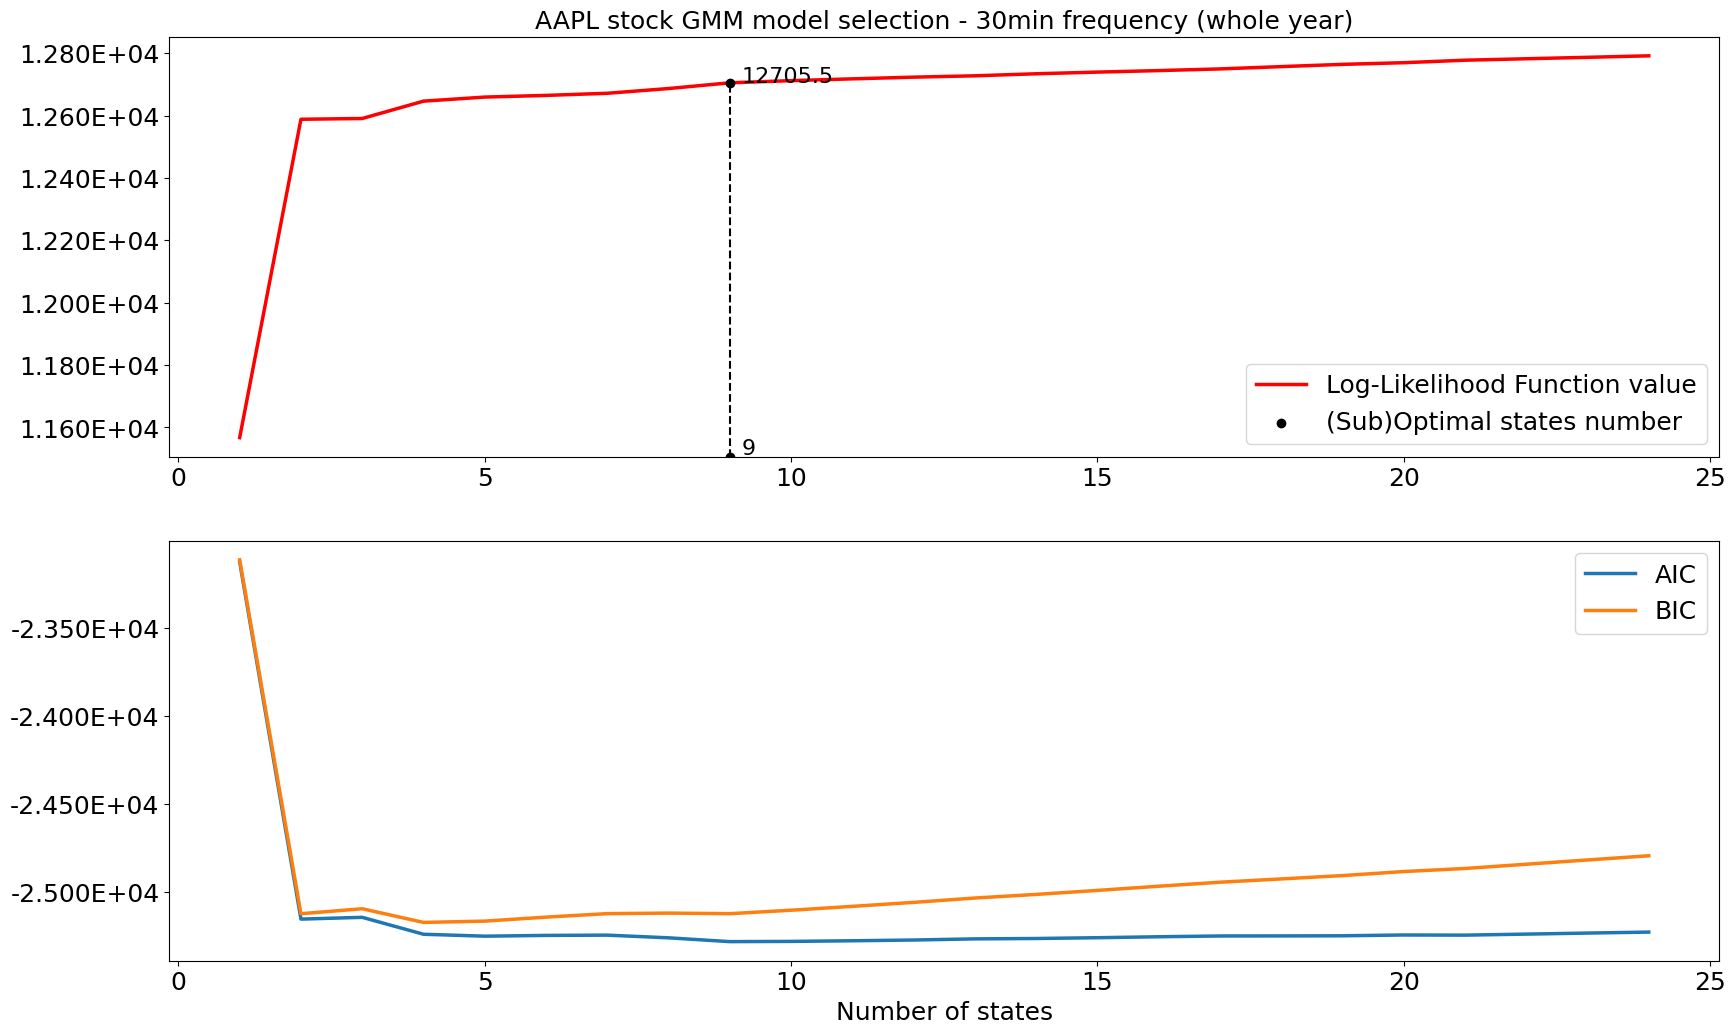

In [25]:
plot_hmm_result(GMM_model_selection(gmm_models_30min)[0], 8, "AAPL stock GMM model selection - 30min frequency (whole year)")

In [26]:
num_min = 9
# Notice that we fitted the model with loss value instead of return value!!
GMM_model = GMM_Model(gmm_models_30min[num_min-1].weights_, gmm_models_30min[num_min-1].means_.flatten(), 
                      np.sqrt(gmm_models_30min[num_min-1].covariances_.flatten()))
GMM_model

,mean,sigma,weight
0,0.000172,0.002354,0.490991
1,-0.003086,0.002789,0.239113
2,0.004719,0.003106,0.151332
3,-0.009875,0.004006,0.050093
4,0.011826,0.004541,0.039690
5,-0.022249,0.005588,0.015767
6,0.032169,0.011852,0.008657
7,-0.046155,0.011268,0.004055
8,0.101885,0.001000,0.000303


In [27]:
Alpha = [0.9, 0.95, 0.99, 0.995, 0.999]
results = pd.DataFrame({"Alpha": Alpha})
results["Empirical"] = np.array([discrete_cvar(loss_30min.values, x)[0] for x in Alpha])
results["GMM"] = np.array([GMM_cvar(GMM_model["weight"], GMM_model["mean"], GMM_model["sigma"], x)[0] for x in Alpha])
results["GMM_diff"] = results["GMM"] - results["Empirical"]
results[["Alpha", "GMM", "Empirical", "GMM_diff"]]

,Alpha,GMM,Empirical,GMM_diff
0,0.900,0.012053,0.011898,0.000155
1,0.950,0.016786,0.016611,0.000175
2,0.990,0.034029,0.033533,0.000497
3,0.995,0.044520,0.042891,0.001630
4,0.999,0.068586,0.066246,0.002339
